In [1]:
import numpy as np

from fpcross import ij, Grid, Solver, Model, Check

ij()

Start | 11:46AM MSK on Oct 23, 2019 | python 3.7.1    |
-------------------------------------------------------


Let solve
$$
    \frac{\partial \psi}{\partial t}
    =
    - A \psi,
    \quad
    \psi(0) = \psi_0,
    \quad
    x \in \Omega,
$$
where
$$
    A \psi
    =
    - \epsilon \Delta \psi
    + div({\psi v}),
$$
with $\epsilon \in R$ and $v \in R^{d}$.

Note that for the case of potential field $v = grad(\phi)$ the analytical solution of the stationary problem is given as $\psi = C e^{-\frac{\phi}{\epsilon}}$, where the constant $C$ is defined to satisfy the normalization condition $\int_{\Omega} \psi \, d x = 1$.

Consider three-dimensional equation (dumbbell model)
$$
    \epsilon=\frac{1}{2},
    \quad
    v = K x - \frac{1}{2} grad(\phi),
    \quad
    x \in [-a, a]^3,
$$
where
$$
    \phi = \frac{1}{2} x^2 + \frac{\alpha}{p^3} e^{-\frac{x^2}{2 p^2}},
$$
and
$$
    K = \beta \begin{bmatrix}
        0 & 1 & 0 \\
        0 & 0 & 0 \\
        0 & 0 & 0
    \end{bmatrix}.
$$

We have
$$
    v
    =
    [v_1, v_2, v_3]^T =
    K x
    - \frac{1}{2} x
    + \frac{\alpha}{2 p^5} e^{-\frac{x^2}{2 p^2}} x,
$$

$$
    \frac{\partial v_1}{\partial x_1}
    =
    - \frac{1}{2}
    + \frac{\alpha}{2 p^5} e^{-\frac{x^2}{2 p^2}}
    - \frac{\alpha}{2 p^7} e^{-\frac{x^2}{2 p^2}} x_1^2,
$$

$$
    \frac{\partial v_2}{\partial x_2}
    =
    - \frac{1}{2}
    + \frac{\alpha}{2 p^5} e^{-\frac{x^2}{2 p^2}}
    - \frac{\alpha}{2 p^7} e^{-\frac{x^2}{2 p^2}} x_2^2,
$$

$$
    \frac{\partial v_3}{\partial x_3}
    =
    - \frac{1}{2}
    + \frac{\alpha}{2 p^5} e^{-\frac{x^2}{2 p^2}}
    - \frac{\alpha}{2 p^7} e^{-\frac{x^2}{2 p^2}} x_3^2.
$$

We select parameter values as in the paper
$$
    \beta = 1,
    \quad
    \alpha = 0.1,
    \quad
    p = 0.5,
    \quad
    x \in [-10, 10]^3,
    \quad
    t \in [0, 10],
    \quad
    \epsilon = 10^{-6}.
$$

In [2]:
a = 0.1
b = 1.
p = 0.5
s = 1.
D = 0.5 * 1.E-6

class Model_(Model):

    def d(self):
        return 3
    
    def D(self):
        return D

    def f0(self, X, t):
        mult = a / 2. / p**5
        mult*= np.exp(-np.sum(X*X, axis=0) / 2. / p**2)
        
        return np.vstack([
            -0.5 * X[0, :] + mult * X[0, :] + b * X[1, :],
            -0.5 * X[1, :] + mult * X[1, :],
            -0.5 * X[2, :] + mult * X[2, :]
        ])

    def f1(self, X, t):
        mult = a / 2. / p**5
        mult*= np.exp(-np.sum(X*X, axis=0) / 2. / p**2)
        
        return np.vstack([
            -0.5 + mult - mult / p**2 * X[0, :],
            -0.5 + mult - mult / p**2 * X[1, :],
            -0.5 + mult - mult / p**2 * X[2, :]
        ])

    def r0(self, X):
        a = 2. * s
        r = np.exp(-np.sum(X*X, axis=0) / a) / (np.pi * a)**1.5
        return r.reshape(-1)

In [3]:
SL = Solver(
    TG=Grid(d=1, n=200, l=[+ 0., +10.], kind='u'),
    SG=Grid(d=3, n=31, l=[-10., +10.], kind='c'),
    MD=Model_(),
    eps=1.E-6, with_tt=True
).init(with_norm_int=True).prep().calc()
SL.info()

Solve: 100%|█| 199/199 [09:53<00:00,  3.66s/step, | At T=1.0e+01 :                                                                                                       Int=4.3e+00  Erhs=2.2e+01 r=2.16e+01]

------------------ Solver
Format    : 3D, TT, eps= 1.00e-06 [order=2]
Format    : 3D, Hst pois  : 10 
Hst r     : No 
Norm int  : Yes 
Err  rhs  : 2.22e+01
Time prep : 8.82e-03 
Time calc : 5.94e+02 
...  init : 2.81e-02 
...  diff : 1.70e+00 
...  conv : 5.74e+02 
...  post : 1.82e+01 
...  last : 5.60e-03 


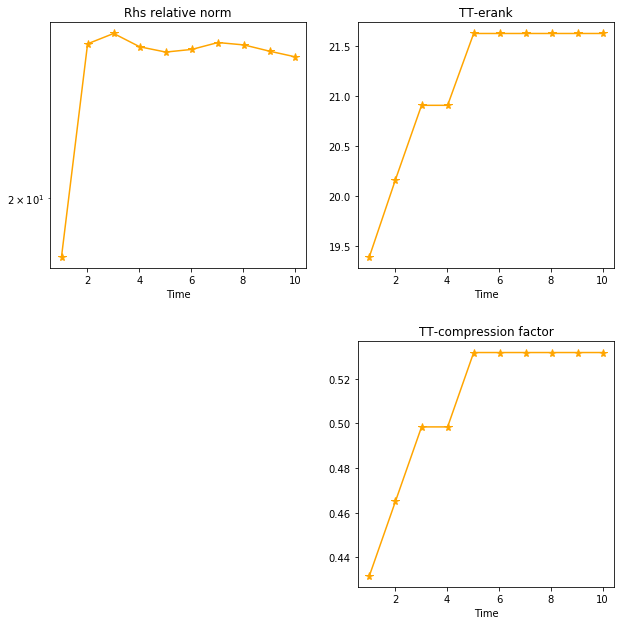

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from fpcross import config

T = SL.hst['T']

fig = plt.figure(figsize=(8, 8))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.2, hspace=0.3, width_ratios=[1, 1], height_ratios=[1, 1]
)
opts = { 'color': 'orange', 'marker': '*', 'markersize': 8, 'markeredgecolor': 'orange' }
    
ax = fig.add_subplot(gs[0, 0]) 
ax.set_title('Rhs relative norm')
ax.set_xlabel('Time')
ax.plot(T, SL.hst['E_rhsn'], **opts)
ax.semilogy()

ax = fig.add_subplot(gs[0, 1])
ax.set_title('TT-erank')
ax.set_xlabel('Time')
ax.plot(T, SL.hst['Rank_E'], **opts)

ax = fig.add_subplot(gs[1, 1])
ax.set_title('TT-compression factor')
ax.set_xlabel('Time')
ax.plot(T, SL.hst['C_size'], **opts)

plt.show()

In [5]:
SL = Solver(
    TG=Grid(d=1, n=10, l=[+ 0., +10.], kind='u'),
    SG=Grid(d=3, n=21, l=[-10., +10.], kind='c'),
    MD=Model_(),
).init().prep().calc()
SL.info()

Solve: 100%|█| 9/9 [01:50<00:00, 11.91s/step, | At T=1.0e+01 :                                                                                                       Int=-9.7e+03  Erhs=8.5e-01]

------------------ Solver
Format    : 3D, NP [order=2]
Format    : 3D, Hst pois  : 10 
Hst r     : No 
Norm int  : No 
Err  rhs  : 8.46e-01
Time prep : 1.84e+00 
Time calc : 1.10e+02 
...  init : 2.74e-03 
...  diff : 9.34e-01 
...  conv : 8.20e-01 
...  post : 1.08e+02 
...  last : 4.80e-03 
